# Decompose the elevation errors into phase and amplitude components

In [1]:
%matplotlib inline

import datetime, time
import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import matplotlib.ticker
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

In [2]:
mom6 = xr.open_dataset('/g/data/nm03/lxy581/evaluate/amp_phase/tides_025_JSL_global.nc')
mmgd = xr.open_dataset('/g/data/nm03/lxy581/archive/tides_025_JSL/output012/ocean_static.nc')
data = xr.open_dataset('/g/data/nm03/lxy581/archive/tides_025_JSL/output011/ocean_interior.nc')
tpxo = xr.open_dataset('/g/data/nm03/TPXO/h_tpxo9.v1.nc')
tpgd = xr.open_dataset('/g/data/nm03/TPXO/grid_tpxo9.nc')

### Read phase and amplitude 

In [3]:
pha_mom6 = mom6.phase / 180*np.pi
amp_mom6 = mom6.amp
pha_tpxo = (tpxo.hp.isel({'nc':0}).transpose() - 180) / 180*np.pi
amp_tpxo = tpxo.ha.isel({'nc':0}).transpose()

### Read grid

In [4]:
lon_mom6 = mmgd.geolon
lat_mom6 = mmgd.geolat
yh, xh = mmgd.yh, mmgd.xh
lon_tpxo = tpgd.lon_z.transpose()
lat_tpxo = tpgd.lat_z.transpose()
ny, nx = tpgd.ny, tpgd.nx

In [5]:
lon_tpxo.shape, lat_tpxo.shape

((1081, 2160), (1081, 2160))

In [6]:
lon_mom6.shape, lat_mom6.shape

((1080, 1440), (1080, 1440))

In [7]:
topog = xr.open_dataset('/home/581/lxy581/tidal_param/MOM6-examples/ocean_only/tides_025/INPUT/ocean_topog.nc')
depth = topog.depth
depth_z = np.array(depth)
depth_z[depth_z==0]=np.nan
depth_da = xr.Dataset(data_vars={'depth_xr': (('yh','xh'), depth_z),
                                }, 
                      coords={'lon': (('yh', 'xh'), np.array(lon_mom6)),
                              'lat': (('yh', 'xh'), np.array(lat_mom6))})
land = xr.where(np.isnan(depth_da.depth_xr[:,:].rename('land')), 1, np.nan)

### Need to interpolate to the same grid - MOM6 grid

In [8]:
ds_tpxo_data = xr.Dataset(data_vars={'pha_tpxo': (('ny','nx'), np.array(pha_tpxo)),
                                     'amp_tpxo': (('ny','nx'), np.array(amp_tpxo))},
                          coords={'lon': (('ny', 'nx'), np.array(lon_tpxo)), 
                                  'lat': (('ny', 'nx'), np.array(lat_tpxo))})
ds_mom6_grid = xr.Dataset({"lat": (["yh","xh"], np.array(lat_mom6)),
                           "lon": (["yh","xh"], np.array(lon_mom6))})
regridder = xe.Regridder(ds_tpxo_data, ds_mom6_grid, "bilinear", extrap_method="inverse_dist")
ds_mom6_grid = regridder(ds_tpxo_data)

In [9]:
ds_mom6_grid['pha_tpxo'].shape, ds_mom6_grid['amp_tpxo'].shape

((1080, 1440), (1080, 1440))

### Calculate TPXO tidal elevation

In [10]:
t_1week  = np.arange(24*7)
nt = t_1week.size
omega_m2 = np.full((nt,yh.size,xh.size),1/12.42)
elev_tpxo = np.array(ds_mom6_grid['amp_tpxo'])[None,:,:] * np.cos(omega_m2 * t_1week[:,None,None] - np.array(ds_mom6_grid['pha_tpxo'])[None,:,:])

In [20]:
np.nanmax(elev_tpxo)

6.9268865739171375

In [12]:
elev_mom6 = np.array(data.e.isel({'time':np.arange(24*7),'zi':0}))

In [21]:
np.nanmax(elev_mom6)

4.9122977

### Calculate the elevation error over the selected period

In [14]:
elev_err = np.sqrt(np.nanmean((elev_mom6 - elev_tpxo)**2,axis=0))

In [15]:
np.nanmean(elev_err)

0.3777568925042646

In [16]:
ele_err_amp = np.sqrt(0.5 * (np.array(amp_mom6) - np.array(ds_mom6_grid['amp_tpxo']))**2)
ele_err_pha = np.sqrt(np.array(amp_mom6) * np.array(ds_mom6_grid['amp_tpxo']) * (1 - np.cos(np.array(pha_mom6) - np.array(ds_mom6_grid['pha_tpxo']))))

### Plot amplitude-induced elevation error and phase-induced elevation error

Start plotting...
0
Plotting error...
1
Plotting amp...
2
Plotting phase...
Saving...


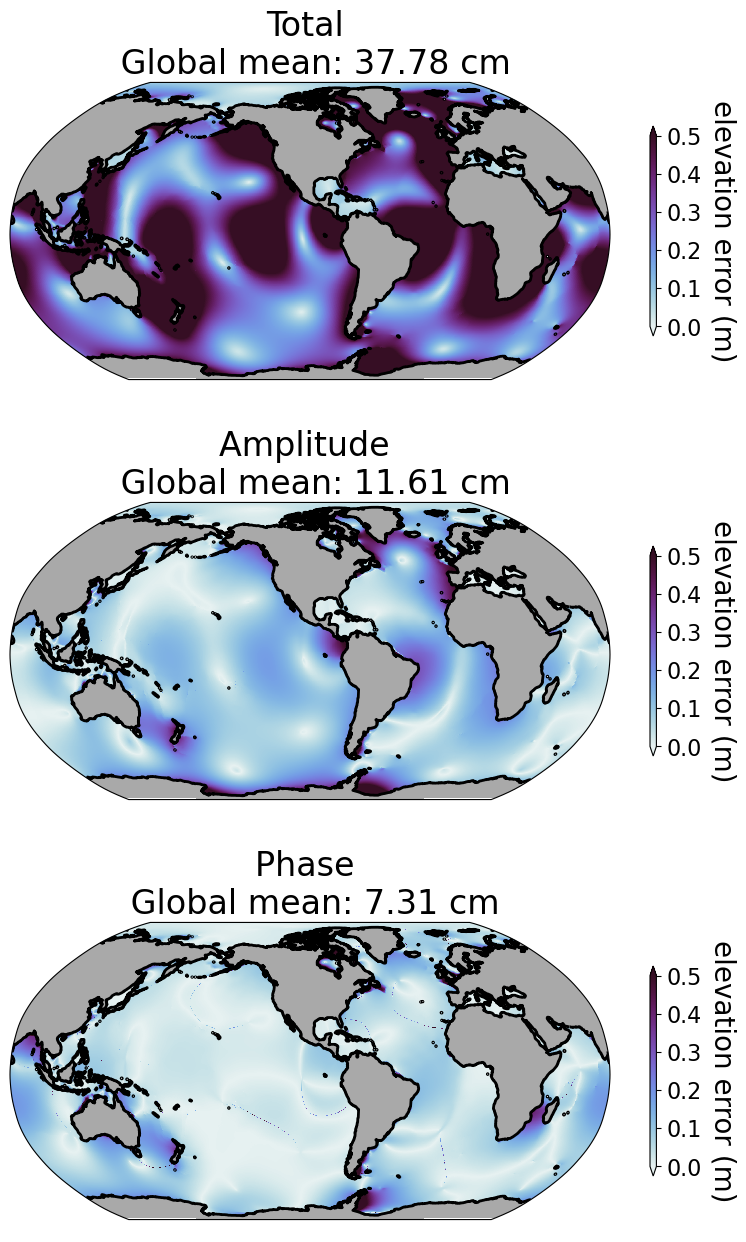

In [22]:
varlist = ['elev_err','ele_err_amp','ele_err_pha']
cb_text = ['elevation error (m)', 'elevation error (m)', 'elevation error (m)']
title   = ['Total \n Global mean: %.2f cm'%np.nanmean(elev_err*100),'Amplitude \n Global mean: %.2f cm'%np.nanmean(ele_err_amp*100), 'Phase \n Global mean: %.2f cm'%np.nanmean(ele_err_pha*100)]

fig = plt.figure(figsize=(8, 14))
axs = []

gridsubs = gridspec.GridSpec(3,1)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

print('Start plotting...')
for I, (ax, var) in enumerate(zip(axs, varlist)):
    print(I)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    # print('Plotting topog...')
    if I<3:
        ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
        # Add model land mask
        land.plot.contourf(ax=ax, x='lon', y='lat', colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
        # Add model coastline
        land.fillna(0).plot.contour(ax=ax, x='lon', y='lat', colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=2)

    if I==0:
        print('Plotting error...')
        p1 = ax.pcolormesh(lon_mom6, lat_mom6, globals()[var], transform=ccrs.PlateCarree(), cmap=cm.cm.dense, vmin=0, vmax=0.5) #norm=LogNorm(vmin=1e-2, vmax=1e-0)
        tick_locs = np.array([0,0.2,0.4,0.6,0.8,1.0])*0.5
        tick_labels = np.array(["0.0","0.1","0.2","0.3","0.4","0.5"])
        ax_cb = plt.axes([0.9, 0.75, 0.008, 0.15])
        cb1 = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
        cb1.ax.set_ylabel(cb_text[I],fontsize=20,rotation=270,labelpad=25);
        cb1.ax.tick_params(labelsize=16)
        cb1.locator   = matplotlib.ticker.FixedLocator(tick_locs)
        cb1.formatter = matplotlib.ticker.FixedFormatter(tick_labels)
        ax.set_position([0.1,0.7,0.75,0.25])
        ax.set_title(title[I],fontsize=24)
    
    if I==1:
        print('Plotting amp...')
        p1 = ax.pcolormesh(lon_mom6, lat_mom6, globals()[var], transform=ccrs.PlateCarree(), cmap=cm.cm.dense, vmin=0, vmax=0.5) #norm=LogNorm(vmin=1e-2, vmax=1e-0)
        tick_locs = np.array([0,0.2,0.4,0.6,0.8,1.0])*0.5
        tick_labels = np.array(["0.0","0.1","0.2","0.3","0.4","0.5"])
        ax_cb = plt.axes([0.9, 0.45, 0.008, 0.15])
        cb1 = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
        cb1.ax.set_ylabel(cb_text[I],fontsize=20,rotation=270,labelpad=25);
        cb1.ax.tick_params(labelsize=16)
        cb1.locator   = matplotlib.ticker.FixedLocator(tick_locs)
        cb1.formatter = matplotlib.ticker.FixedFormatter(tick_labels)
        ax.set_position([0.1,0.4,0.75,0.25])
        ax.set_title(title[I],fontsize=24)


    if I==2:
        print('Plotting phase...')
        p1 = ax.pcolormesh(lon_mom6, lat_mom6, globals()[var], transform=ccrs.PlateCarree(), cmap=cm.cm.dense, vmin=0, vmax=0.5)
        tick_locs = np.array([0,0.2,0.4,0.6,0.8,1.0])*0.5
        tick_labels = np.array(["0.0","0.1","0.2","0.3","0.4","0.5"])
        ax_cb = plt.axes([0.9, 0.15, 0.008, 0.15])
        cb1 = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
        cb1.ax.set_ylabel(cb_text[I],fontsize=20,rotation=270,labelpad=25);
        cb1.ax.tick_params(labelsize=16)
        cb1.locator   = matplotlib.ticker.FixedLocator(tick_locs)
        cb1.formatter = matplotlib.ticker.FixedFormatter(tick_labels)
        ax.set_position([0.1,0.1,0.75,0.25])
        ax.set_title(title[I],fontsize=24)

print('Saving...')
plt.savefig('/g/data/nm03/lxy581/evaluate/amp_phase/MOM6_JSL_M2_decompose_amp_pha.png', dpi=300, bbox_inches='tight')

In [18]:
np.sqrt(11.61**2 + 7.31**2)

13.71962827484768